# Examen de programación

La información teórica fue obtenida del libro *Time Series Econometrics: Learning Through Replication. Springer. (2023)* de Levendis, J. D. 

In [1]:
# !pip install pandas numpy seaborn statsmodels

import pandas as pd
import numpy as np
import seaborn as sns
from dateparser import parse
import warnings
warnings.filterwarnings('ignore')

## Limpieza de datos

El método preferente para extraer los datos de INEGI es por medio de la API usando el código token y la librería INEGIpy, sin embargo, dado que ha presentado inestabilidad, decidí descargarlas de forma individual y procesarlas con código para unirlas. 
La base de datos fue limpiada y después exportada para su uso para el script de R, cuya libreria de inegiR también estaba presentando dificultades.

A pesar de estas limitaciones técnicas, toda la información utilizada en el estudio fue obtenida directamente del Banco de Información Económica (BIE), empleando los índices en cifras originales, es decir, sin ajuste estacional.

In [2]:
# Funciones auxiliares para cargar datos y construir la base
def load_data(file, col_name):
    df = pd.read_csv(file, encoding='latin1')
    df['ds'] = df.iloc[:, 0].apply(lambda x: parse(x, languages=['es']))
    s = df.set_index('ds').sort_index()['DATA'].rename(col_name)
    return s.dropna()


def build_df(files, names):
    series = [load_data(f, name) for f, name in zip(files, names)]
    df_wide = pd.concat(series, axis=1)
    df_long = (
        df_wide
        .reset_index()
        .melt(id_vars='ds', var_name='unique_id', value_name='y')
    )
    return df_long

In [3]:
files = [
    'https://raw.githubusercontent.com/jadrk040507/analisis-mifel/refs/heads/master/data/igae.csv', 
    'https://raw.githubusercontent.com/jadrk040507/analisis-mifel/refs/heads/master/data/consumo.csv', 
    'https://raw.githubusercontent.com/jadrk040507/analisis-mifel/refs/heads/master/data/inversion.csv']
names = ['igae', 'consumo', 'inversion']

df = build_df(files, names)

In [4]:
df.to_csv('data/series.csv', index=False)

In [5]:
df.head()

,ds,unique_id,y
0,1993-01-19,igae,55.43
1,1993-02-19,igae,56.46
2,1993-03-19,igae,58.90
3,1993-04-19,igae,57.14
4,1993-05-19,igae,57.89


## Análisis exporatorio

In [6]:
# Función auxiliar para gráficar
def plot_facets(df_long, value_col, ylabel, title):
    '''
    Plot Facets: Permite graficar series de tiempo en formato long de forma rápida.
    '''
    ax = sns.relplot(df_long, x='ds', y=value_col, kind='line', col='unique_id')
    ax.set_ylabels(ylabel)
    ax.set_xlabels('')
    ax.set_titles('{col_name}')
    ax.fig.suptitle(title, y=1.05)
    return ax

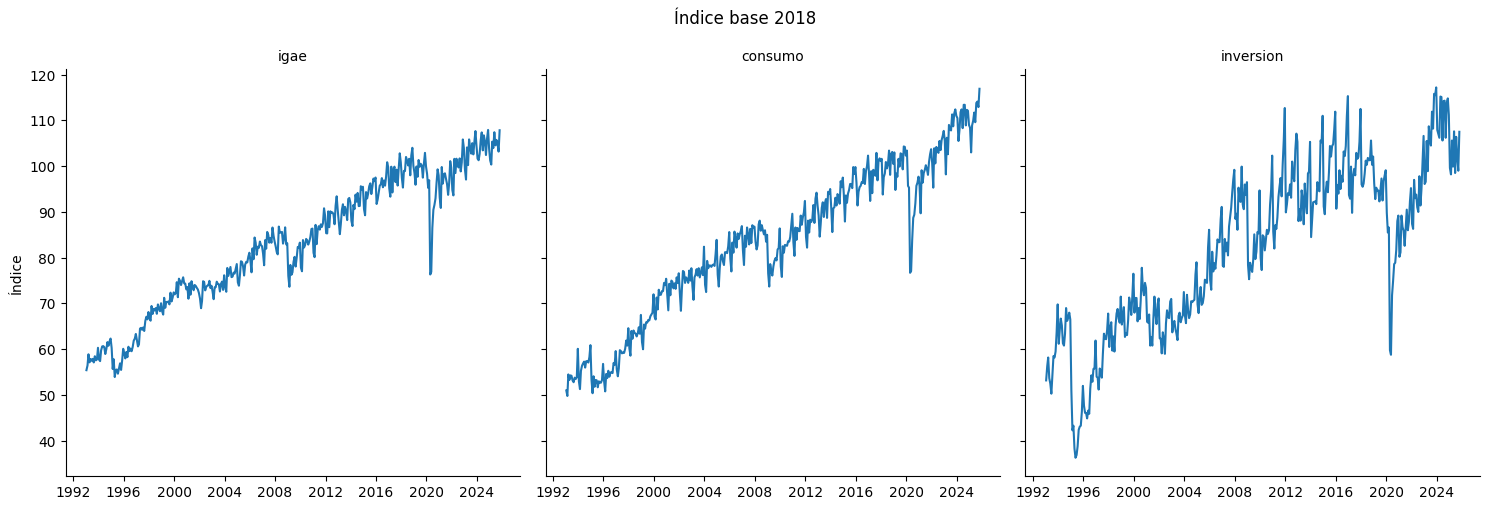

In [7]:
plot_facets(df, 'y', 'Índice', 'Índice base 2018')

In [8]:
# Cambio porcentual anual
df['yoy'] = df.groupby('unique_id')['y'].pct_change(periods=12) * 100
df.tail()

,ds,unique_id,y,yoy
1177,2025-06-19,inversion,98.5,-6.723485
1178,2025-07-19,inversion,106.4,-6.830123
1179,2025-08-19,inversion,101.8,-10.936133
1180,2025-09-19,inversion,99.0,-6.779661
1181,2025-10-19,inversion,107.5,-5.536028


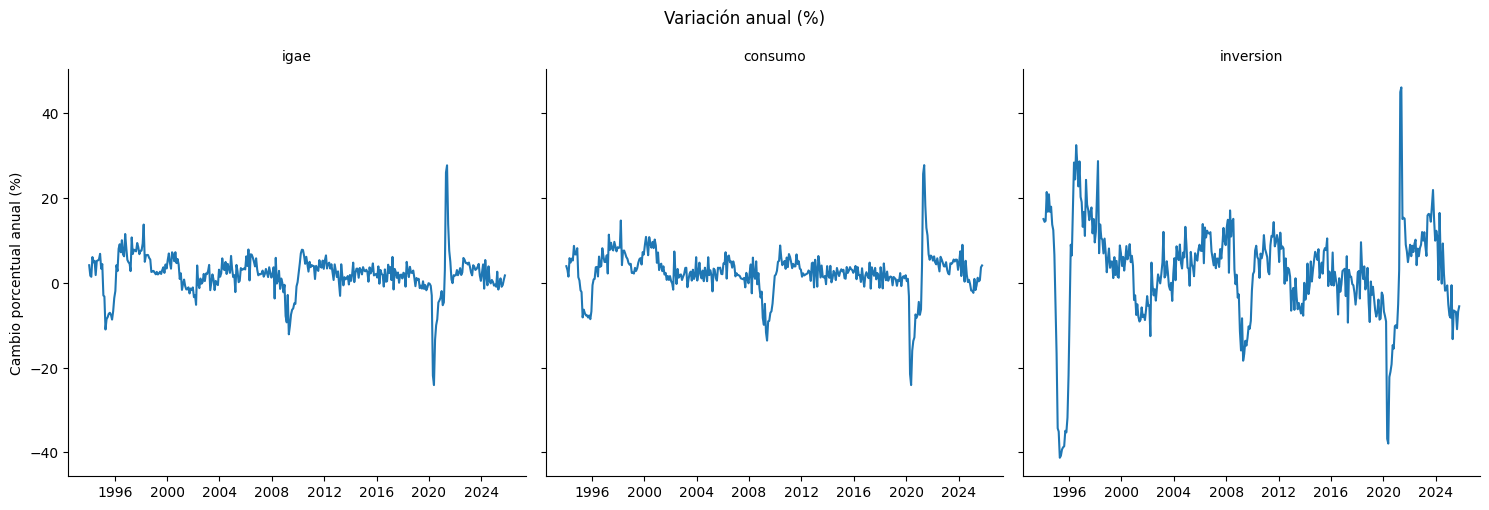

In [9]:
plot_facets(df, 'yoy', 'Cambio porcentual anual (%)', 'Variación anual (%)')

## Pruebas de estacionariedad

El test de ADF (Dickey-Fuller Aumentado por sus siglas en inglés) es una prueba de cointegración de la forma

$$
\Delta y_t = \alpha + \gamma y_{t-1} + \sum_{k=1}^{p-1} \delta_k \Delta y_{t-p} + \varepsilon_t
$$

Donde $\gamma = \left(\sum_k^p\beta_k\right) - 1$, por lo tanto si $\beta \to 1$ entonces $y_t$ es una serie de raíz unitaria. La $H_0$ es que el proceso es de raíz unitaria, mientras que $H_1$ es que la serie no es un random walk. Los términos $ \delta_k \Delta y_{t-p}$ se incluyen para ajustar por la autocorrelación. 
El estadístico sigue un distribución Dickey-Fuller, similar a la t-Student, pero con un ajuste en los valores críticos.


El test KPSS (Kwiatkowski-Phillips-Schmidt-Shin) es una prueba LM (multiplicador de Lagrange) que tiene forma 

$$
LM = \frac{(\text{score})^2}{\text{information}} = \frac{\sum_{t=0}^{T}S_t^2}{\hat{\sigma}_\varepsilon^2}
$$

Partimos de que el modelo se descompone en los componentes: tendencia deterministica ($\beta t$), componente estocástico ($r_t$) y error ($\varepsilon_t$).
$$
y_t = \beta t + r_t + \varepsilon_t
$$
El componente estocástico evoluciona como:
$$
r_t = r_{t-1} + u_t, \quad u_t \sim iid(0, \sigma_u^2)
$$

La $H_0 : \sigma_u^2 = 0$, implica que $u_t=0$ y $r_t = r_0$. El modelo se reduce a
$$
y_t = \beta t + r_0 + \varepsilon_t
$$
Esto es un modelo estacionario alrededor de una tendencia determinística. Bajo $H_1$ la serie $y_t$ tiene una tendencia estocástica (caminata aleatoria).

In [10]:
# Funciones auxiliares para las pruebas de raíz unitaria
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(series, autolag='AIC'):
    stat, pval, lags, nobs, crit, _ = adfuller(
        series.dropna(),
        autolag=autolag
    )
    
    return pd.DataFrame({
        'adf_stat': [stat],
        'p_value': [pval],
        'n_lags': [lags],
        'n_obs': [nobs]
    })


def kpss_test(series, regression='ct'):
    stat, pval, lags, crit = kpss(
        series.dropna(),
        regression=regression,
        nlags='auto'
    )
    
    return pd.DataFrame({
        'kpss_stat': [stat],
        'kpss_p': [pval],
        'kpss_lags': [lags]
    })

In [11]:
adf_df =  df.groupby('unique_id')['y'].apply(adf_test)
kpss_df = df.groupby('unique_id')['y'].apply(kpss_test)

C:\Users\jadrk\AppData\Local\Temp\ipykernel_8640\375060821.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, pval, lags, crit = kpss(
C:\Users\jadrk\AppData\Local\Temp\ipykernel_8640\375060821.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, pval, lags, crit = kpss(
C:\Users\jadrk\AppData\Local\Temp\ipykernel_8640\375060821.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, pval, lags, crit = kpss(


In [12]:
display(adf_df)
display(kpss_df)

,,adf_stat,p_value,n_lags,n_obs
unique_id,,,,,
consumo,0,-0.489784,0.893995,15,378
igae,0,-0.910879,0.784369,12,381
inversion,0,-1.273876,0.641038,16,377


,,kpss_stat,kpss_p,kpss_lags
unique_id,,,,
consumo,0,0.294556,0.01,11
igae,0,0.226482,0.01,10
inversion,0,0.273560,0.01,11


La prueba de Dickey–Fuller Aumentada (ADF) fue implementada tanto en Python como en R, con diferencias en la determinación del número de rezagos. En Python, el número óptimo de rezagos se seleccionó de manera endógena utilizando el criterio de información de Akaike (AIC), el cual penaliza la inclusión de parámetros adicionales y busca un balance entre ajuste y parsimonia. Bajo esta especificación, los resultados del test ADF indican que, para todas las series, no se rechaza la hipótesis nula de presencia de raíz unitaria incluso al nivel de significancia del 1%, lo que sugiere que las series no son estacionarias en nivel.

En contraste, en R la implementación del test ADF utiliza una selección de rezagos fija, lo que conduce a resultados ligeramente distintos. En particular, para las series de consumo y del IGAE se rechaza la hipótesis nula de raíz unitaria al nivel de significancia del 5%, aunque no al 1%, mientras que para la inversión no se encuentra evidencia suficiente para rechazar la hipótesis nula. Estos resultados constituyen evidencia mixta respecto a la estacionariedad en nivel de algunas series.

De manera complementaria, se aplicó la prueba KPSS, cuya hipótesis nula establece que la serie es estacionaria en nivel o alrededor de una tendencia determinística. En todos los casos, el estadístico KPSS permite rechazar la hipótesis nula al nivel de significancia convencional, lo que indica la presencia de tendencias estocásticas en las series.

En conjunto, considerando la sensibilidad de la prueba ADF a la especificación del número de rezagos y la evidencia robusta proporcionada por la prueba KPSS, se concluye que las series presentan comportamiento compatible con procesos integrados de orden uno. Por lo tanto, a efectos del análisis posterior, todas las series se tratan como no estacionarias en nivel.

## Primera diferencia

In [13]:
# Aplicación de primera diferencia
df['dy'] = df.groupby('unique_id')['y'].diff()

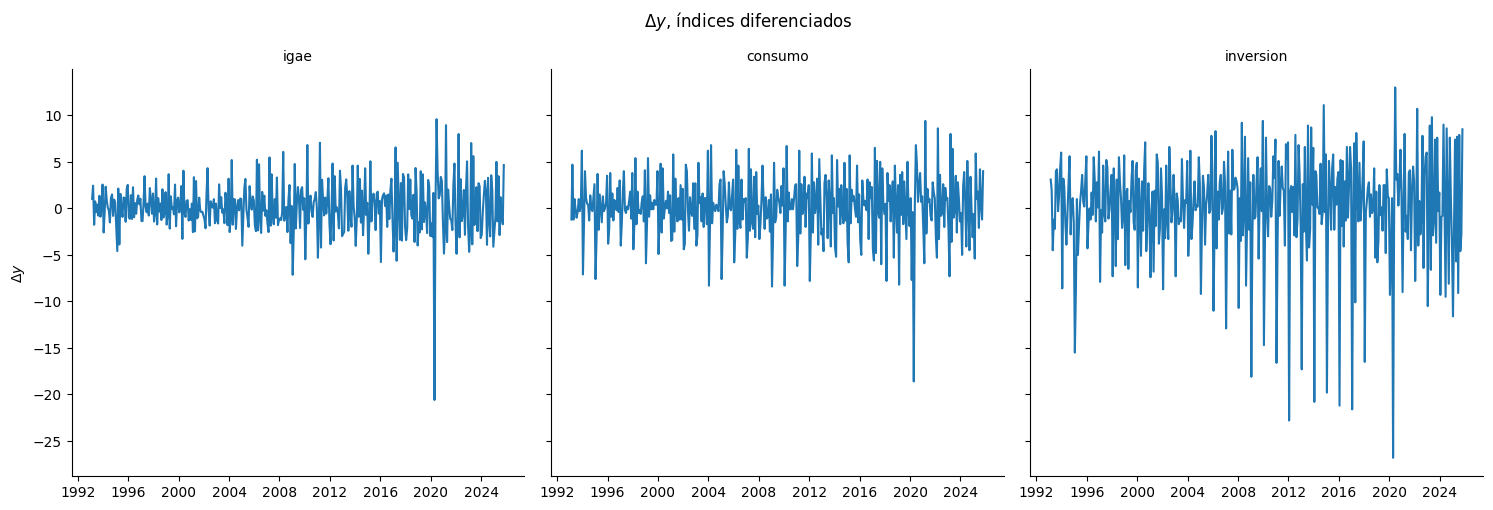

In [14]:
plot_facets(df, 'dy', r'$\Delta y$', r'$\Delta y$, índices diferenciados')

In [15]:
adf_dy =  df.groupby('unique_id')['dy'].apply(adf_test)
kpss_dy = df.groupby('unique_id')['dy'].apply(kpss_test, regression='c')

C:\Users\jadrk\AppData\Local\Temp\ipykernel_8640\375060821.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, pval, lags, crit = kpss(
C:\Users\jadrk\AppData\Local\Temp\ipykernel_8640\375060821.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, pval, lags, crit = kpss(
C:\Users\jadrk\AppData\Local\Temp\ipykernel_8640\375060821.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, pval, lags, crit = kpss(


In [16]:
display(adf_dy)
display(kpss_dy)

,,adf_stat,p_value,n_lags,n_obs
unique_id,,,,,
consumo,0,-6.116366,9.074281e-08,14,378
igae,0,-6.636171,5.555631e-09,11,381
inversion,0,-5.167105,1.025852e-05,15,377


,,kpss_stat,kpss_p,kpss_lags
unique_id,,,,
consumo,0,0.043804,0.1,16
igae,0,0.047920,0.1,31
inversion,0,0.029017,0.1,18


El mismo procedimiento se aplicó a la primera diferencia de cada serie. A diferencia del análisis en niveles, los resultados del test ADF para las series diferenciadas permiten rechazar la hipótesis nula de presencia de raíz unitaria, lo que indica que las primeras diferencias son estacionarias en nivel.

De manera complementaria, se aplicó la prueba KPSS a las series en primera diferencia. Dado que la diferenciación elimina cualquier componente de tendencia determinística, la prueba se especificó únicamente con constante. En todos los casos, no se rechaza la hipótesis nula de estacionariedad, lo que confirma que las series diferenciadas son estacionarias.

En conjunto, los resultados de las pruebas ADF y KPSS indican que todas las series son integradas de orden uno, ya que no son estacionarias en nivel, pero sí lo son después de aplicar la primera diferencia.

## Pruebas de cointegración

Existen diversas metodologías para realizar pruebas de cointegración. En sistemas bivariados es común utilizar el procedimiento de Engle--Granger, el cual consiste en un enfoque de dos etapas. En la primera etapa se estima la relación de largo plazo
$$
Y_t = \beta' X_t + \varepsilon_t,
$$

y en la segunda se aplica una prueba de raíz unitaria, como el test ADF, a los residuos estimados. Si los residuos resultan estacionarios, se concluye que existe cointegración entre las variables.

Sin embargo, para sistemas con más de dos variables resulta más apropiado emplear el test de Johansen, el cual es un enfoque multivariado basado en un modelo de corrección de error (VECM). Este procedimiento permite determinar el número de relaciones de cointegración mediante dos pruebas distintas: el test del máximo eigenvalor y el test de la traza. Ambos son pruebas de razón de verosimilitud construidas a partir de los eigenvalores de la matriz $\Pi$, la cual contiene toda la información sobre las relaciones de largo plazo del sistema.

El modelo VECM puede escribirse como:
$$
\Delta Y_t = \sum_{i=1}^{k-1} \Gamma_i \Delta Y_{t-i} + \Pi Y_{t-1} + (\gamma + \tau t) + \varepsilon_t.
$$

La matriz $\Pi$ determina la existencia de cointegración. Si el sistema contiene $n$ variables, puede haber a lo sumo $n-1$ relaciones linealmente independientes de cointegración. Cuando $\Pi$ no es de rango completo, es decir, es singular, su determinante es igual a cero, lo cual implica que al menos uno de sus eigenvalores es igual a cero. El número de relaciones de cointegración es igual al número de eigenvalores distintos de cero de $\Pi$.

Dado que los verdaderos eigenvalores de $\Pi$ no son observables, el test de Johansen utiliza sus estimaciones muestrales y procede de manera secuencial. En el test del máximo eigenvalor se contrasta la hipótesis nula de que el rango de $\Pi$ es $r$ frente a la alternativa de que es $r+1$, utilizando el estadístico:
$$
LR(r, r+1) = -T \ln(1 - \lambda_{r+1}).
$$
El procedimiento inicia con $r=0$ y se incrementa sucesivamente hasta que no se rechaza la hipótesis nula.

Por su parte, el test de la traza contrasta la hipótesis nula de que el rango de $\Pi$ es menor o igual a $r$ frente a la alternativa de que es mayor que $r$, utilizando el estadístico:
$$
LR(r,n) = -T \sum_{i=r+1}^{n} \ln(1 - \lambda_i).
$$
A diferencia del test de máximo eigenvalor, el test de la traza evalúa de manera conjunta la contribución de todos los eigenvalores restantes, permitiendo identificar el número total de relaciones de cointegración en el sistema.

In [17]:
# Se realiza un modelo VAR con el vector (igae, consumo, inversión)' para extraer el orden de rezagos para incluir en la prueba de Johansen. 
from statsmodels.tsa.api import VAR

df_wide = df.pivot(columns='unique_id', values='y', index='ds')

model = VAR(df_wide[['igae','consumo','inversion']].dropna())
lag_order = model.select_order(12)
lag_order.summary()

C:\Users\jadrk\Dropbox\Mifel\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,10.87,10.90,5.250e+04,10.88
1,5.768,5.892,319.9,5.817
2,5.315,5.532,203.3,5.401
3,5.116,5.425,166.6,5.239
4,5.017,5.420,150.9,5.177
5,4.742,5.237,114.6,4.938
6,4.734,5.323,113.8,4.968
7,4.645,5.327,104.1,4.916
8,4.439,5.214,84.76,4.747
9,4.423,5.291,83.44,4.768


In [18]:
# Función auxiliar para realizar prueba de Johansen de traza y máximo-eigenvalor
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def johansen_table(data, det_order=0, k_ar_diff=1, signif=0.05):
    result = coint_johansen(data, det_order, k_ar_diff)
    if signif == 0.10:
        crit_col = 0
    elif signif == 0.05:
        crit_col = 1
    elif signif == 0.01:
        crit_col = 2
    else:
        raise ValueError("signif must be 0.10, 0.05 or 0.01")

    n = data.shape[1]

    table = pd.DataFrame({
        'r': range(n),
        'trace_stat': result.lr1,
        'trace_crit': result.cvt[:, crit_col],
        'trace_reject': result.lr1 > result.cvt[:, crit_col],
        'maxeig_stat': result.lr2,
        'maxeig_crit': result.cvm[:, crit_col],
        'maxeig_reject': result.lr2 > result.cvm[:, crit_col]
    })

    return table

In [19]:
johansen_table(
    df_wide[['igae', 'consumo', 'inversion']],
    det_order=1,
    k_ar_diff=lag_order.aic - 1,
    signif=0.05
)

,r,trace_stat,trace_crit,trace_reject,maxeig_stat,maxeig_crit,maxeig_reject
0,0,23.214799,35.0116,False,14.369440,24.2522,False
1,1,8.845359,18.3985,False,5.566549,17.1481,False
2,2,3.278810,3.8415,False,3.278810,3.8415,False


De acuerdo con los resultados obtenidos a partir de las pruebas de cointegración de Johansen, se concluye que el sistema no presenta cointegración. Tanto el test de la traza como el test del máximo eigenvalor se evalúan de manera secuencial. En ambos casos, no se rechaza la hipótesis nula de ausencia de cointegración para $r=0$. Dado que no se rechaza para $r=0$, no es necesario continuar con las siguientes hipótesis nulas.

En consecuencia, no se identifica una combinación lineal estacionaria entre el IGAE, el consumo y la inversión. A pesar de que las series individuales son integradas de orden uno, no comparten una tendencia común de largo plazo.

## Transformación logarítmica y regresión

In [20]:
# Transformación logarítmica de la serie
df['ly'] = np.log(df['y'])

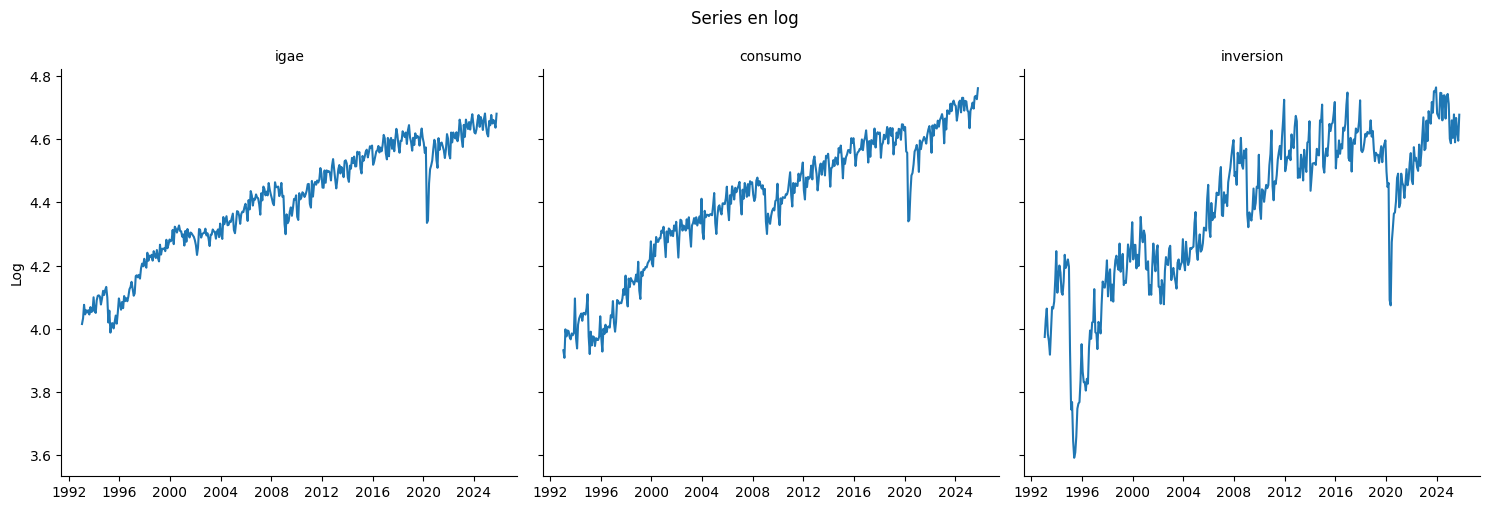

In [21]:
plot_facets(df, 'ly', 'Log', 'Series en log')

In [22]:
# Regresión lineal
import statsmodels.api as sm
import statsmodels.formula.api as smf

ly_wide = df.pivot(columns='unique_id', index='ds', values='ly')

model = (smf.ols('igae ~ consumo + inversion', ly_wide)
    .fit(
    cov_type="HAC",
    cov_kwds={"maxlags": 12}
        ))
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   igae   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     1713.
Date:                Mon, 19 Jan 2026   Prob (F-statistic):          3.41e-194
Time:                        08:08:13   Log-Likelihood:                 904.51
No. Observations:                 394   AIC:                            -1803.
Df Residuals:                     391   BIC:                            -1791.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7541      0.064     11.733      0.000       0.628       0.880
consumo        0.7382      0.038     19.565      0.000       0.664       0.812
inversion      0.0919      0.033      2.792      0.005       0.027       0.156
==============================================================================
Omnibus:                        3.410   Durbin-Watson:                   0.563
Prob(Omnibus):                  0.182   Jarque-Bera (JB):                2.741
Skew:                          -0.084   Prob(JB):                        0.254
Kurtosis:                       2.627   Cond. No.                         136.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 12 lags and without small sample correction
"""

El modelo de regresión propuesto captura relaciones promedio entre las variables, aunque no es adecuado para realizar inferencia causal ni para fines predictivos. Bajo esta especificación en logaritmos, los coeficientes estimados se interpretan como elasticidades; es decir, miden el cambio porcentual promedio en la variable dependiente ante un cambio de $1\%$ en la variable independiente. En particular, la estimación sugiere que un aumento de $1\%$ en el consumo se asocia, en promedio, con un incremento aproximado de $0.74\%$ en el IGAE, que actúa como proxy del PIB. De manera análoga, un aumento de $1\%$ en la inversión se asocia con un incremento promedio cercano a $0.09\%$ en el IGAE.

Con el fin de corregir posibles problemas de heterocedasticidad y autocorrelación en los residuos, se emplearon errores estándar robustos de tipo HAC (Newey-West). Tras este ajuste, los coeficientes de interés resultaron estadísticamente significativos al nivel del $1\%$, o cercanos a dicho umbral, de acuerdo con los valores $p$ obtenidos. El uso de errores HAC incrementa la incertidumbre asociada a las estimaciones al ampliar los errores estándar. Asimismo, pueden observarse ligeras discrepancias respecto a estimaciones realizadas en Python, lo cual se explica porque la librería *statsmodels* utiliza aproximaciones asintóticas para la inferencia, mientras que en R se emplea la distribución $t$ de Student, resultando en inferencia más conservadora. Recordemos que el valor $p$ representa la probabilidad, bajo la hipótesis nula, de observar un estadístico al menos tan extremo como el obtenido, y está directamente relacionado con la probabilidad de cometer un error tipo I ($\alpha$).

El estadístico $F$ rechaza la hipótesis nula de que, conjuntamente, los coeficientes de los regresores (excluyendo la constante) sean iguales a cero, lo que indica que el modelo proporciona un mejor ajuste que una especificación que solo incluya la media del logaritmo del IGAE. El coeficiente de determinación $R^2$ y su versión ajustada indican una elevada proporción de la varianza explicada, lo cual es consistente con que las series tienen una tendencia positiva a pesar de que no estén cointegradas. No obstante, este buen ajuste no debe interpretarse como evidencia de causalidad ni de capacidad predictiva fuera de muestra, ya que el modelo no incorpora explícitamente la dinámica de corto plazo ni el mecanismo de corrección de error.

Finalmente, los estadísticos de Jarque-Bera y Omnibus se utilizan para evaluar la normalidad de los residuos a partir del sesgo y la curtosis. En este caso, no se rechaza la hipótesis nula de normalidad, lo que sugiere que los residuos no presentan desviaciones significativas respecto a una distribución normal.
